# Substellar profiles of temperature and heating rates.

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Data analysis and viz libraries
import aeolus.plot as aplt
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
# Local modules
import mypaths
from calc import dry_lapse_rate, heating_rate_lw, heating_rate_sw
from commons import MODELS
from const_ben1_hab1 import hecto, kilo
from names import names
from plot_func import KW_SBPLT_LABEL, figsave

In [4]:
plt.style.use("paper.mplstyle")

## Choose cases

In [5]:
THAI_cases = ["Hab1", "Hab2"]

## Load the data

Load the data previously preprocessed: time mean and standard deviation.

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
datasets_std = {}
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    datasets_std[THAI_case] = {}
    for model_key in MODELS.keys():
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc"
        )
        datasets_std[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_time_std_{model_key}.nc"
        )
        if model_key in ["ROCKE3D"]:
            # Convert pressure from hPa to Pa for ROCKE-3D
            datasets[THAI_case][model_key][names[model_key].pres] *= hecto
            datasets_std[THAI_case][model_key][names[model_key].pres] *= hecto

## Substellar point coordinates
The data will be interpolated to these coordinates.

In [7]:
SS_POINT = dict(longitude=0, latitude=0)

## Define variables to plot
* `"func"`: a method of extraction from the dataset
* `"xlim"`: limits of the main x-axis
* `"xlim_inset"`: limits of the inset x-axis

In [8]:
VPROF_VRBL = {
    "temp": {
        "func": lambda ds, mk: ds[names[mk].temp],
        "title": "Temperature",
        "tex_units": "$K$",
        "xlim": {"Hab1": [160, 305], "Hab2": [160, 320]},
        "xlim_inset": {"Hab1": [260, 300], "Hab2": [295, 325]},
        "axins_bounds": [0.5, 0.5, 0.45, 0.45],
    },
    "dtempdz": {
        "func": lambda ds, mk: dry_lapse_rate(ds, mk) * kilo,
        "title": "Lapse rate",
        "tex_units": "$K$ $km^{-1}$",
        "xlim": {"Hab1": [-37.5, 7.5], "Hab2": [-55, 30]},
        "xlim_inset": {"Hab1": [-15, 5], "Hab2": [-15, 5]},
        "axins_bounds": [0.15, 0.5, 0.45, 0.45],
    },
    "dt_sw": {
        "func": heating_rate_sw,
        "title": "Shortwave heating rate",
        "tex_units": "$K$ $day^{-1}$",
        "xlim": {"Hab1": [0, 30], "Hab2": [0, 350]},
        "xlim_inset": {"Hab1": [0, 10], "Hab2": [0, 15]},
        "axins_bounds": [0.5, 0.15, 0.45, 0.45],
    },
    "dt_lw": {
        "func": heating_rate_lw,
        "title": "Longwave heating rate",
        "tex_units": "$K$ $day^{-1}$",
        "xlim": {"Hab1": [-22.5, 7.5], "Hab2": [-310, 25]},
        "xlim_inset": {"Hab1": [-5, 5], "Hab2": [-10, 10]},
        "axins_bounds": [0.15, 0.15, 0.45, 0.45],
    },
}

Define pressure axis parameters

In [9]:
ylabel = "Pressure [$hPa$]"
ylim = 1000, 0.01
yticks = 1000, 100, 10, 1, 0.1
ylim_inset = 1000, 100
yticks_inset = 1000, 750, 500, 250

## Plot the results
Loop over THAI cases, then over variables and `axes` and then over models.

Saved to ../plots/Hab1__vprof__ss_point__temp_dtempdz_dt_sw_dt_lw.png
Saved to ../plots/Hab2__vprof__ss_point__temp_dtempdz_dt_sw_dt_lw.png


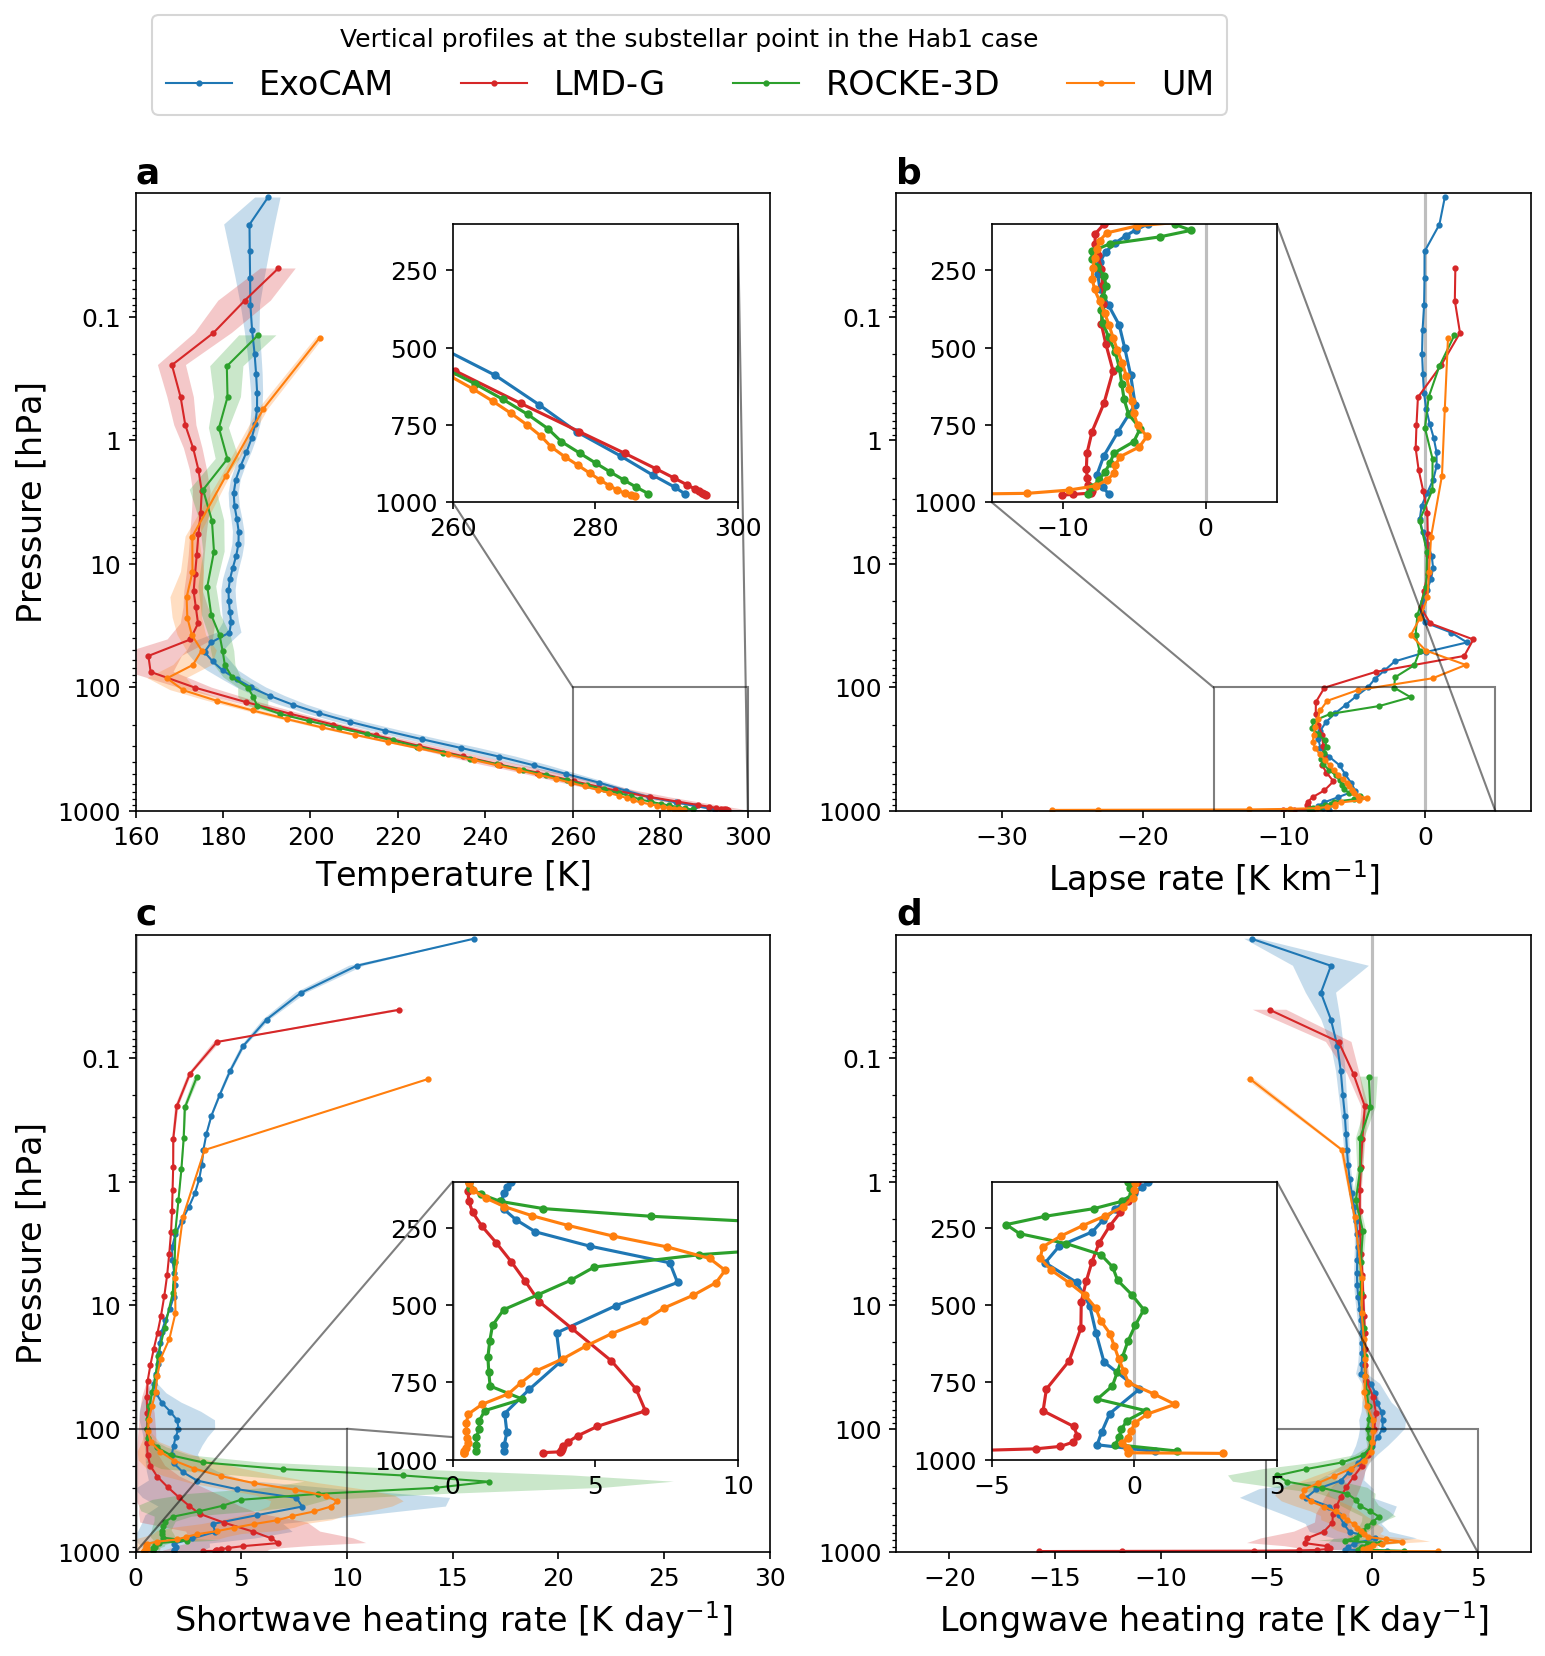

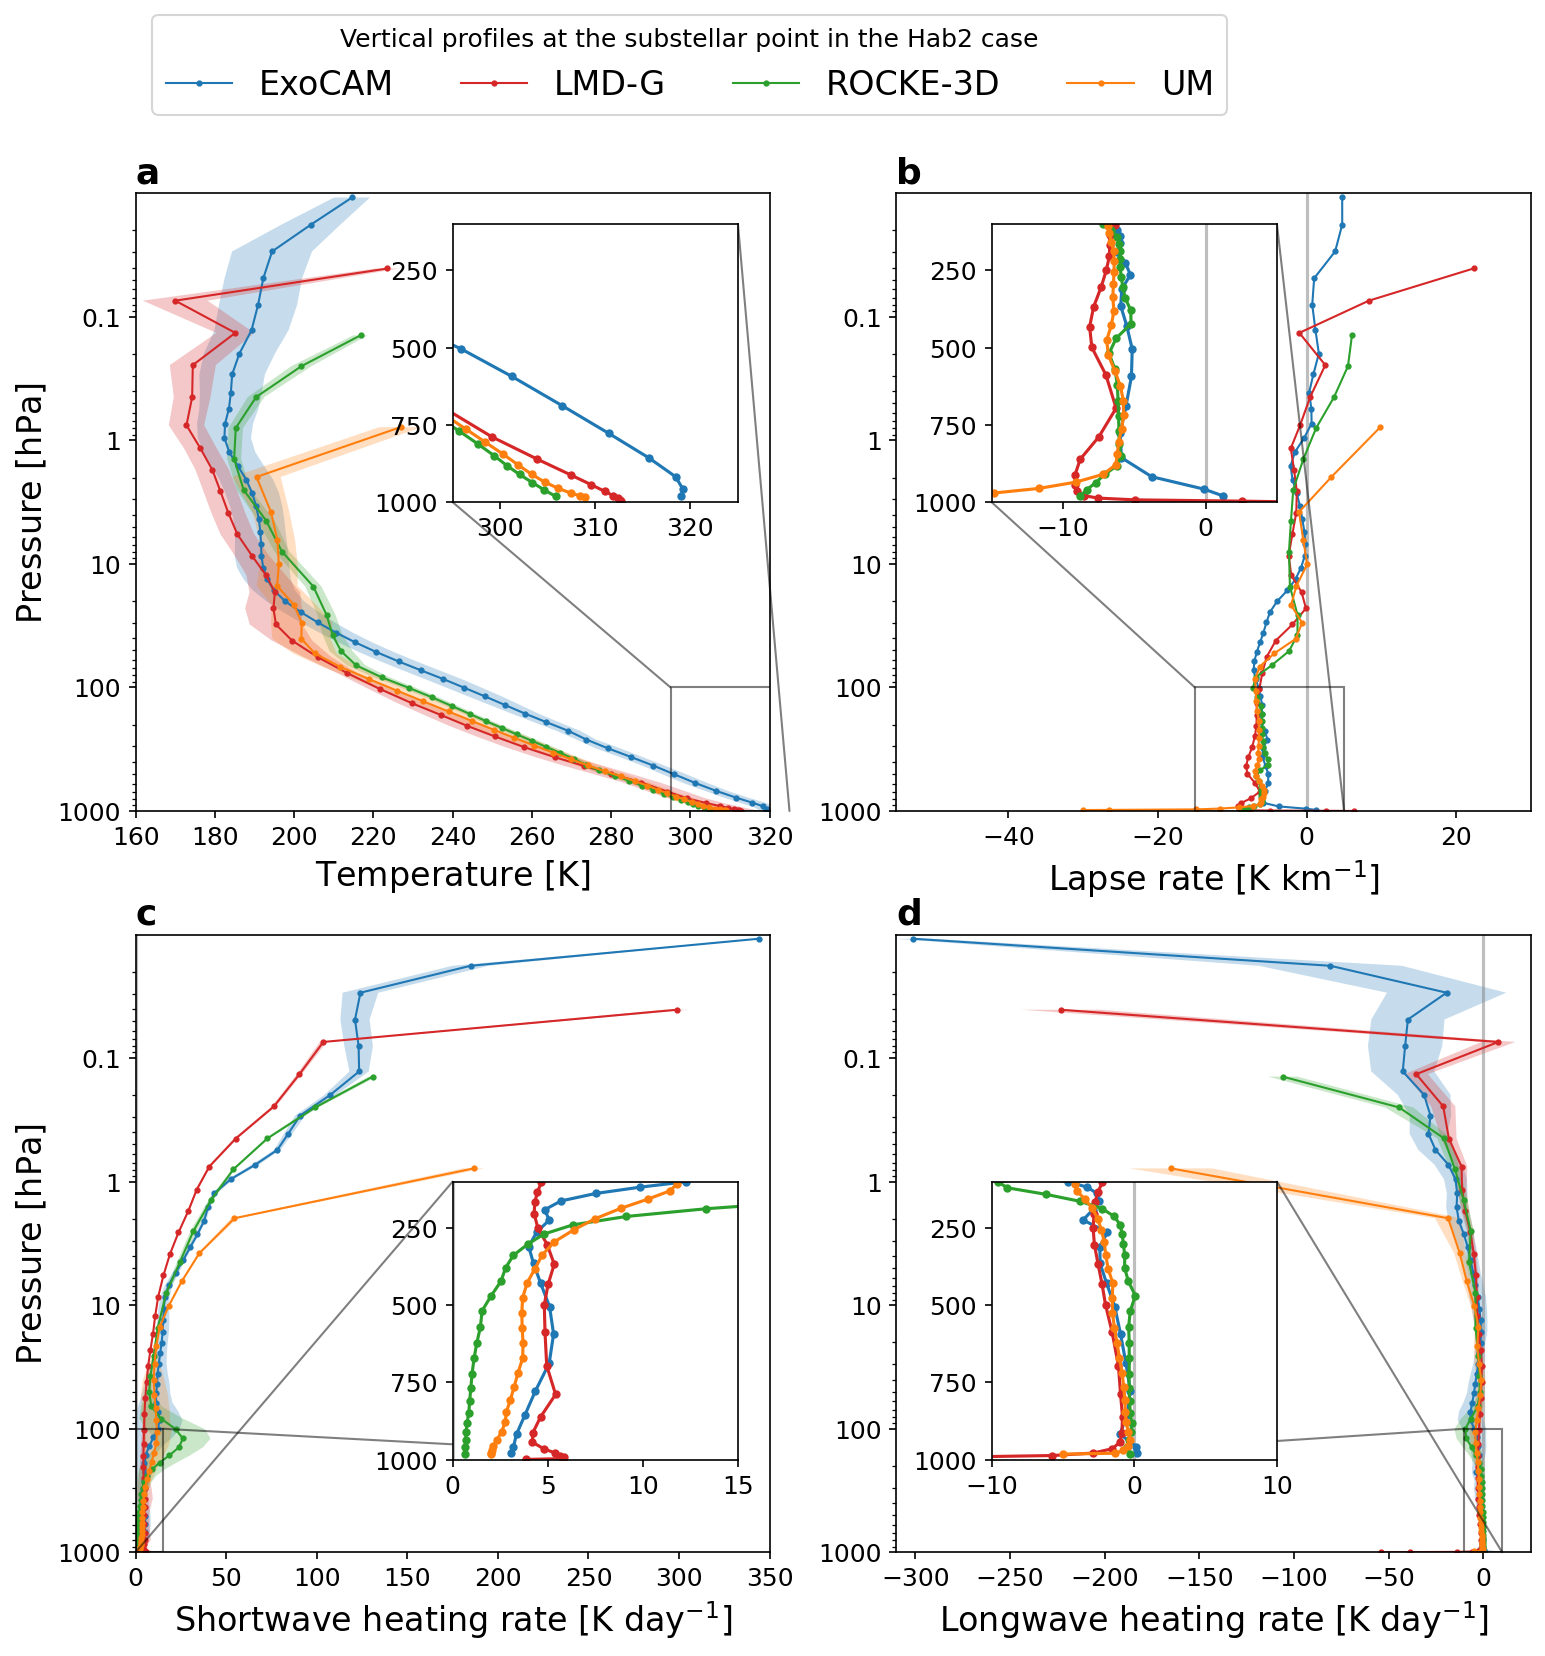

In [10]:
for THAI_case in THAI_cases:

    ncols = 2
    nrows = 2

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6 * ncols, 6 * nrows))

    iletters = aplt.subplot_label_generator()
    for (varkey, vardict), ax in zip(VPROF_VRBL.items(), axs.flat):
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(ylabel)
        ax.set_xlabel(f"{vardict['title']} [{vardict['tex_units']}]")
        ax.set_yscale("log")
        ax.set_ylim(ylim)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
        ax.set_xlim(vardict["xlim"][THAI_case])
        if np.sign(vardict["xlim"][THAI_case][0]) != np.sign(vardict["xlim"][THAI_case][1]):
            ax.axvline(color="tab:grey", alpha=0.5)
        axins = ax.inset_axes(vardict["axins_bounds"])
        axins.set_ylim(ylim_inset)
        axins.set_yticks(yticks_inset)
        axins.set_yticklabels(yticks_inset)
        axins.set_xlim(vardict["xlim_inset"][THAI_case])
        if np.sign(vardict["xlim_inset"][THAI_case][0]) != np.sign(
            vardict["xlim_inset"][THAI_case][1]
        ):
            axins.axvline(color="tab:grey", alpha=0.5)
        ax.indicate_inset_zoom(axins, edgecolor="black")

        for model_key, model_dict in MODELS.items():
            model_names = names[model_key]
            ds = datasets[THAI_case][model_key]
            y = ds[model_names.pres].interp(**SS_POINT) / hecto
            x = vardict["func"](ds, model_key).interp(**SS_POINT)
            if varkey != "dtempdz":
                ds_std = datasets_std[THAI_case][model_key]
                x_std = vardict["func"](ds_std, model_key).interp(**SS_POINT)
                ax.fill_betweenx(
                    y, x - x_std, x + x_std, color=model_dict["color"], edgecolor="none", alpha=0.25
                )

            ax.plot(
                x,
                y,
                marker=".",
                ms=4,
                linewidth=1,
                color=model_dict["color"],
                label=model_dict["title"],
            )
            axins.plot(x, y, marker=".", ms=6, linewidth=1.5, color=model_dict["color"])
    ttl = f"Vertical profiles at the substellar point in the {THAI_case} case"
    axs.flatten()[0].legend(title=ttl, ncol=len(MODELS), loc="lower left", bbox_to_anchor=(0, 1.1))
    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__vprof__ss_point__{'_'.join(VPROF_VRBL.keys())}",
    )